In [1]:
import nevergrad as ng

print(f"Optimizers: {sorted(ng.optimizers.registry.keys())}\n")
print(f"Version: {ng.__version__}\n")
# 查看 CMA 优化器的参数
help(ng.optimizers.CMA)

'''
'''CMA是被封装后的Optimizer API: 
Optimizer API
All the optimizers share the following common API:
classnevergrad.optimizers.base.Optimizer(parametrization: Union[int, Parameter], budget: Optional[int] = None, num_workers: int = 1)
所以直接调用CMA只能接受(parametrization, budget, num_workers)三个参数

Optimizers: ['ASCMADEthird', 'AX', 'AdaptiveDiscreteOnePlusOne', 'AlmostRotationInvariantDE', 'AnisotropicAdaptiveDiscreteOnePlusOne', 'AvgMetaRecenteringNoHull', 'BAR', 'BAR2', 'BAR3', 'BAR4', 'BFGS', 'BO', 'BOBYQA', 'BOSplit', 'BayesOptimBO', 'CM', 'CMA', 'CMAbounded', 'CMApara', 'CMAsmall', 'CMAstd', 'CMAtuning', 'CMandAS2', 'CMandAS3', 'Carola1', 'Carola2', 'Carola3', 'CauchyLHSSearch', 'CauchyOnePlusOne', 'CauchyScrHammersleySearch', 'ChainCMAPowell', 'ChainDiagonalCMAPowell', 'ChainMetaModelPowell', 'ChainMetaModelSQP', 'ChainNaiveTBPSACMAPowell', 'ChainNaiveTBPSAPowell', 'ChoiceBase', 'CmaFmin2', 'Cobyla', 'DE', 'DiagonalCMA', 'DiscreteBSOOnePlusOne', 'DiscreteDE', 'DiscreteDoerrOnePlusOne', 'DiscreteLengler2OnePlusOne', 'DiscreteLengler3OnePlusOne', 'DiscreteLenglerFourthOnePlusOne', 'DiscreteLenglerHalfOnePlusOne', 'DiscreteLenglerOnePlusOne', 'DiscreteLenglerOnePlusOneT', 'DiscreteOnePlusOne', 'DiscreteOnePlusOneT', 'DoubleFastGADiscreteOnePlusOne', 'EDA', 'ES', 'F2SQPCMA', '

'CMA是被封装后的Optimizer API: \nOptimizer API\nAll the optimizers share the following common API:\nclassnevergrad.optimizers.base.Optimizer(parametrization: Union[int, Parameter], budget: Optional[int] = None, num_workers: int = 1)\n所以直接调用CMA只能接受(parametrization, budget, num_workers)三个参数\n'

In [ ]:
#####   基础配置 源代码   ######
class _CMA(base.Optimizer):
    _CACHE_KEY = "#CMA#datacache"

    def __init__(
        self,
        parametrization: IntOrParameter,
        budget: tp.Optional[int] = None,
        num_workers: int = 1,
        config: tp.Optional["ParametrizedCMA"] = None,
        algorithm: str = "quad",
    ) -> None:
        super().__init__(parametrization, budget=budget, num_workers=num_workers)
        self.algorithm = algorithm
        self._config = ParametrizedCMA() if config is None else config
        pop = self._config.popsize
        self._popsize = (
            max(num_workers, 4 + int(self._config.popsize_factor * np.log(self.dimension)))
            if pop is None
            else max(pop, num_workers)
        )
        if self._config.elitist:
            self._popsize = max(self._popsize, self.num_workers + 1)
        # internal attributes
        self._to_be_asked: tp.Deque[np.ndarray] = deque()
        self._to_be_told: tp.List[p.Parameter] = []
        self._num_spawners = self._popsize // 2  # experimental, for visualization
        self._parents = [self.parametrization]
        # delay initialization to ease implementation of variants
        self._es: tp.Any = None

    @property
    def es(self) -> tp.Any:  # typing not possible since cmaes not imported :(
        scale_multiplier = 1.0
        if self.dimension == 1:
            self._config.fcmaes = True
        if p.helpers.Normalizer(self.parametrization).fully_bounded:
            scale_multiplier = 0.3 if self.dimension < 18 else 0.15
        if self._es is None or (not self._config.fcmaes and self._es.stop()):
            if not self._config.fcmaes:
                import cma  # import inline in order to avoid matplotlib initialization warning

                inopts = dict(
                    popsize=self._popsize,
                    randn=self._rng.randn,
                    CMA_diagonal=self._config.diagonal,
                    verbose=-9,
                    seed=np.nan,
                    CMA_elitist=self._config.elitist,
                )

                inopts.update(self._config.inopts if self._config.inopts is not None else {})
                self._es = cma.CMAEvolutionStrategy(
                    x0=self.parametrization.sample().get_standardized_data(reference=self.parametrization)
                    if self._config.random_init
                    else np.zeros(self.dimension, dtype=np.float_),
                    sigma0=self._config.scale * scale_multiplier,
                    inopts=inopts,
                )
            else:
                try:
                    from fcmaes import cmaes
                except ImportError as e:
                    raise ImportError(
                        "Please install fcmaes (pip install fcmaes) to use FCMA optimizers"
                    ) from e
                self._es = cmaes.Cmaes(
                    x0=np.zeros(self.dimension, dtype=np.float_),
                    input_sigma=self._config.scale * scale_multiplier,
                    popsize=self._popsize,
                    randn=self._rng.randn,
                )
        return self._es

    def _internal_ask_candidate(self) -> p.Parameter:
        if not self._to_be_asked:
            self._to_be_asked.extend(self.es.ask())
        data = self._to_be_asked.popleft()
        parent = self._parents[self.num_ask % len(self._parents)]
        candidate = parent.spawn_child().set_standardized_data(data, reference=self.parametrization)
        return candidate

    def _internal_tell_candidate(self, candidate: p.Parameter, loss: tp.FloatLoss) -> None:
        if self._CACHE_KEY not in candidate._meta:
            # since we try several times to tell to es, to avoid duplicated work let's keep
            # the data in a cache. This can be useful for other CMA as well
            candidate._meta[self._CACHE_KEY] = candidate.get_standardized_data(reference=self.parametrization)
        self._to_be_told.append(candidate)
        if len(self._to_be_told) >= self.es.popsize:
            listx = [c._meta[self._CACHE_KEY] for c in self._to_be_told]
            listy = [c.loss for c in self._to_be_told]
            args = (listy, listx) if self._config.fcmaes else (listx, listy)
            try:
                self.es.tell(*args)
            except (RuntimeError, AssertionError):
                pass
            else:
                self._parents = sorted(self._to_be_told, key=base._loss)[: self._num_spawners]
            self._to_be_told = []

    def _internal_provide_recommendation(self) -> np.ndarray:
        pessimistic = self.current_bests["pessimistic"].parameter.get_standardized_data(
            reference=self.parametrization
        )
        d = self.dimension
        n = self.num_ask
        sample_size = int(d * d / 2 + d / 2 + 3)
        if self._config.high_speed and n >= sample_size:
            try:
                data = learn_on_k_best(self.archive, sample_size, self.algorithm)
                return data  # type: ignore
            except MetaModelFailure:  # Failures in the metamodeling can happen.
                pass
        if self._es is None:
            return pessimistic
        cma_best: tp.Optional[np.ndarray] = self.es.best_x if self._config.fcmaes else self.es.result.xbest
        if cma_best is None:
            return pessimistic
        return cma_best


class ParametrizedCMA(base.ConfiguredOptimizer):
    """CMA-ES optimizer,
    This evolution strategy uses Gaussian sampling, iteratively modified
    for searching in the best directions.
    This optimizer wraps an external implementation: https://github.com/CMA-ES/pycma

    Parameters
    ----------
    scale: float
        scale of the search
    elitist: bool
        whether we switch to elitist mode, i.e. mode + instead of comma,
        i.e. mode in which we always keep the best point in the population.
    popsize: Optional[int] = None
        population size, should be n * self.num_workers for int n >= 1.
        default is max(self.num_workers, 4 + int(3 * np.log(self.dimension)))
    popsize_factor: float = 3.
        factor in the formula for computing the population size
    diagonal: bool
        use the diagonal version of CMA (advised in big dimension)
    high_speed: bool
        use metamodel for recommendation
    fcmaes: bool
        use fast implementation, doesn't support diagonal=True.
        produces equivalent results, preferable for high dimensions or
        if objective function evaluation is fast.
    random_init: bool
        Use a randomized initialization
    inopts: optional dict
        use this to averride any inopts parameter of the wrapped CMA optimizer
        (see https://github.com/CMA-ES/pycma)   
    """

    # pylint: disable=unused-argument
    def __init__(
        self,
        *,
        scale: float = 1.0,
        elitist: bool = False,
        popsize: tp.Optional[int] = None,
        popsize_factor: float = 3.0,
        diagonal: bool = False,
        zero: bool = False,
        high_speed: bool = False,
        fcmaes: bool = False,
        random_init: bool = False,
        inopts: tp.Optional[tp.Dict[str, tp.Any]] = None,
        algorithm: str = "quad",
    ) -> None:
        super().__init__(_CMA, locals(), as_config=True)
        if zero:
            scale = scale / 1000.0
        if fcmaes:
            if diagonal:
                raise RuntimeError("fcmaes doesn't support diagonal=True, use fcmaes=False")
        self.scale = scale
        self.elitist = elitist
        self.zero = zero
        self.popsize = popsize
        self.popsize_factor = popsize_factor
        self.diagonal = diagonal
        self.fcmaes = fcmaes
        self.high_speed = high_speed
        self.random_init = random_init
        self.inopts = inopts

In [ ]:
#####   variations 源代码   ######
@registry.register
class ChoiceBase(base.Optimizer):
    """Nevergrad optimizer by competence map."""

    # pylint: disable=too-many-branches
    def __init__(
        self, parametrization: IntOrParameter, budget: tp.Optional[int] = None, num_workers: int = 1
    ) -> None:
        super().__init__(parametrization, budget=budget, num_workers=num_workers)
        analysis = p.helpers.analyze(self.parametrization)
        funcinfo = self.parametrization.function
        self.has_noise = not (analysis.deterministic and funcinfo.deterministic)
        # The noise coming from discrete variables goes to 0.
        self.noise_from_instrumentation = self.has_noise and funcinfo.deterministic
        self.fully_continuous = analysis.continuous
        all_params = p.helpers.flatten(self.parametrization)
        # figure out if there is any discretization layers
        int_layers = list(
            itertools.chain.from_iterable([_layering.Int.filter_from(x) for _, x in all_params])
        )
        int_layers = [x for x in int_layers if x.arity is not None]  # only "Choice" instances for now
        self.has_discrete_not_softmax = any(
            not isinstance(lay, _datalayers.SoftmaxSampling) for lay in int_layers
        )
        self._has_discrete = bool(int_layers)
        self._arity: int = max((lay.arity for lay in int_layers), default=-1)  # type: ignore
        if self.fully_continuous:
            self._arity = -1
        self._optim: tp.Optional[base.Optimizer] = None
        self._constraints_manager.update(
            max_trials=1000,
            penalty_factor=1.0,
            penalty_exponent=1.01,
        )

    @property
    def optim(self) -> base.Optimizer:
        if self._optim is None:
            # try:
            self._optim = self._select_optimizer_cls()(self.parametrization, self.budget, self.num_workers)
            # except:
            #    self._optim = NGOpt39._select_optimizer_cls(self)(self.parametrization, self.budget, self.num_workers)
            self._optim = self._optim if not isinstance(self._optim, NGOptBase) else self._optim.optim
            logger.debug("%s selected %s optimizer.", *(x.name for x in (self, self._optim)))
        return self._optim

    def _select_optimizer_cls(self) -> base.OptCls:
        return CMA

    def _internal_ask_candidate(self) -> p.Parameter:
        return self.optim.ask()

    def _internal_tell_candidate(self, candidate: p.Parameter, loss: tp.FloatLoss) -> None:
        self.optim.tell(candidate, loss)

    def recommend(self) -> p.Parameter:
        return self.optim.recommend()

    def _internal_tell_not_asked(self, candidate: p.Parameter, loss: tp.FloatLoss) -> None:
        self.optim.tell(candidate, loss)

    def _info(self) -> tp.Dict[str, tp.Any]:
        out = {"sub-optim": self.optim.name}
        out.update(self.optim._info())  # this will work for recursive NGOpt calls
        return out

    def enable_pickling(self) -> None:
        self.optim.enable_pickling()


OldCMA = ParametrizedCMA().set_name("OldCMA", register=True)
LargeCMA = ParametrizedCMA(scale=3.0).set_name("LargeCMA", register=True)
LargeDiagCMA = ParametrizedCMA(scale=3.0, diagonal=True).set_name("LargeDiagCMA", register=True)
TinyCMA = ParametrizedCMA(scale=0.33).set_name("TinyCMA", register=True)
CMAbounded = ParametrizedCMA(scale=1.5884, popsize_factor=1, elitist=True, diagonal=True, fcmaes=False).set_name("CMAbounded", register=True)
CMAsmall = ParametrizedCMA(scale=0.3607, popsize_factor=3, elitist=False, diagonal=False, fcmaes=False).set_name("CMAsmall", register=True)
CMAstd = ParametrizedCMA(scale=0.4699, popsize_factor=3, elitist=False, diagonal=False, fcmaes=False).set_name("CMAstd", register=True)
CMApara = ParametrizedCMA(scale=0.8905, popsize_factor=8, elitist=True, diagonal=True, fcmaes=False).set_name("CMApara", register=True)
CMAtuning = ParametrizedCMA(scale=0.4847, popsize_factor=1, elitist=True, diagonal=False, fcmaes=False).set_name("CMAtuning", register=True)


@registry.register
class MetaCMA(ChoiceBase):  # Adds Risto's CMA to CMA.
    """Nevergrad optimizer by competence map. You might modify this one for designing your own competence map."""

    def _select_optimizer_cls(self) -> base.OptCls:
        if (
            self.budget is not None
            and self.fully_continuous
            and not self.has_noise
            and self.num_objectives < 2
        ):
            if self.dimension == 1:
                return OnePlusOne
            if p.helpers.Normalizer(self.parametrization).fully_bounded:
                return CMAbounded
            if self.budget < 50:
                if self.dimension <= 15:
                    return CMAtuning
                return CMAsmall
            if self.num_workers > 20:
                return CMApara
            return CMAstd
        else:
            return OldCMA


DiagonalCMA = ParametrizedCMA(diagonal=True).set_name("DiagonalCMA", register=True)
SDiagonalCMA = ParametrizedCMA(diagonal=True, zero=True).set_name("SDiagonalCMA", register=True)
FCMA = ParametrizedCMA(fcmaes=True).set_name("FCMA", register=True)

@registry.register
class CMA(MetaCMA):
    pass


In [10]:
import nevergrad as ng

# Define a multi-objective optimization problem
def multi_objective_function(x):
    objective1 = (x[0] - 2) ** 2 + (x[1] - 3) ** 2
    objective2 = (x[0] + 1) ** 2 + (x[1] + 2) ** 2
    return [objective1, objective2]

# Create the optimization function using CMA-ES
optimizer = ng.optimizers.CMA(parametrization=2, budget=100)

# Minimize the multi-objective function
recommendation = optimizer.minimize(multi_objective_function)

# Display the results
print("Best parameters:", recommendation.args[0])
print("Objective values:", recommendation.value)

Best parameters: None
Objective values: None


In [12]:
import nevergrad as ng

# Define a multi-objective optimization problem
def multi_objective_function(x):
    objective1 = (x[0] - 2) ** 2 + (x[1] - 3) ** 2
    objective2 = (x[0] + 1) ** 2 + (x[1] + 2) ** 2
    return [objective1, objective2]

# Define the scalarization method (e.g., weighted sum)
def scalarization(x):
    weights = [1.0, 2.0]  # Adjust the weights based on your preference
    return sum(w * f for w, f in zip(weights, multi_objective_function(x)))

# Create the optimization function using CMA-ES
optimizer = ng.optimizers.CMA(parametrization=2, budget=100)

# Minimize the scalarized function
recommendation = optimizer.minimize(scalarization)

# Display the results
print("Best parameters:", recommendation.args[0])
print("Objective values:", multi_objective_function(recommendation.args[0]))


Best parameters: [-0.00191087 -0.32837241]
Objective values: [15.085710038338252, 3.7905207074363054]


In [ ]:
import nevergrad as ng

# Define the objective function with constraints
def objective_function(x):
    # Constraint: x[0] > 0
    if x[0] <= 0:
        return float('inf')  # Return infinity for infeasible solutions
    return sum((x - 2) ** 2)

# Create the optimization problem
optimization_problem = ng.p.Instrumentation(ng.p.Scalar().set_bounds(-5, 5).set_integer_casting())

# Create the CMA-ES optimizer
optimizer = ng.optimizers.CMA(parametrization=optimization_problem, budget=100)

# Run the optimization
recommendation = optimizer.minimize(objective_function)

# Display the results
print("Best parameters:", recommendation.args[0])
print("Objective value:", recommendation.value)


In [ ]:
# Toy Example

import nevergrad as ng
#import cma
#import warnings
#warnings.simplefilter("ignore", cma.evolution_strategy.InjectionWarning)

# Objective function (example: Rosenbrock function)
def objective_function(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# Create optimization problem object
optimization_problem = ng.p.Array(shape=(5,)).set_bounds(-5, 5)

# Create CMA-ES optimizer object
optimizer = ng.optimizers.CMA(parametrization=optimization_problem, budget=5000, num_workers=3)

# Run optimization
recommendation = optimizer.minimize(objective_function)

# Get the best parameters and the best value
best_params = recommendation.value
best_value = objective_function(best_params)

print(f"Best parameters: {best_params}")
print(f"Best value: {best_value}")

In [5]:
# Toy Example

import nevergrad as ng

# Objective function (example: Rosenbrock function)
def objective_function(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

# Create optimization problem object
optimization_problem = ng.p.Array(shape=(5,)).set_bounds(-5, 5)

# Create CMA-ES optimizer object
optimizer = ng.optimizers.CMA(parametrization=optimization_problem, budget=5000, num_workers=1)

# Run optimization
recommendation = optimizer.minimize(objective_function)

# Get the best parameters and the best value
best_params = recommendation.value
best_value = objective_function(best_params)

print(f"Best parameters: {best_params}")
print(f"Best value: {best_value}")


Best parameters: [0.9580152  0.91663593 0.83913293 0.70468587 0.49485486]
Best value: 0.1223810481316821


In [2]:
# Variation Example

import nevergrad as ng

# Objective function
def objective_function(x):
    return sum(x**2)

# Create the parameter space
optimization_problem = ng.p.Array(shape=(4,)).set_bounds(-5, 5)

# Get the algorithm configuration for CMAbounded from the registry
cma_config = ng.optimizers.registry["CMAbounded"]

# Create an instance of the CMAbounded optimizer using the configuration
optimizer = cma_config(parametrization=optimization_problem, budget=1000)

# Run the optimization
recommendation = optimizer.minimize(objective_function)

# Get the best parameters and the best value
best_params = recommendation.value
best_value = objective_function(best_params)

print(f"Best parameters: {best_params}\n")
print(f"Best value: {best_value}")

Best parameters: [-0.01123025  0.00256679 -0.00233787  0.00961406]

Best value: 0.0002306026983469772


$f(\mathbf{x}) = 10 n + \sum_{i=1}^{n} [x_i^2 - 10 \cos(2 \pi x_i)]$


$-5.12 \leq x_i \leq 5.12$


# Objective Functions

In [6]:
import nevergrad as ng
import numpy as np
# Set the random seed for reproducibility
np.random.seed(1)
# Define the Rastrigin function as mentioned above
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Create an optimization problem object
parametrization = ng.p.Array(shape=(2,)).set_bounds(lower=-5.12, upper=5.12)
optimizer = ng.optimizers.CMA(parametrization=parametrization, budget=100)

# Create a CMA-ES optimizer object
for i in range(optimizer.budget):
    x = optimizer.ask()  # Ask for a new candidate solution
    value = rastrigin(x.value)  # Compute the value of the Rastrigin function
    optimizer.tell(x, value)  # Feedback the result to the optimizer

# Retrieve the best solution
recommendation = optimizer.provide_recommendation()
print(f"Recommended solution: {recommendation.value}, function value: {rastrigin(recommendation.value)}")


Recommended solution: [ 7.55008127e-05 -6.69666250e-06], function value: 1.1398057750966473e-06


In [9]:
import time

# List of CMA-ES variants to test
cma_variants = ["CMAbounded", "LargeCMA", "TinyCMA", "CMAsmall", "CMAstd", "CMApara", "CMAtuning"]

# Run each variant
for variant in cma_variants:
    np.random.seed(1)  # Ensure reproducibility
    optimizer = ng.optimizers.registry[variant](parametrization=parametrization, budget=100)

    start_time = time.time()
    for _ in range(optimizer.budget):
        x = optimizer.ask()
        optimizer.tell(x, rastrigin(x.value))
    duration = time.time() - start_time

    recommendation = optimizer.provide_recommendation()
    print(f"{variant}: Best value {rastrigin(recommendation.value)} in {duration} seconds")



CMAbounded: Best value 0.9949634787264188 in 0.2188107967376709 seconds
LargeCMA: Best value 2.668496944533608 in 0.21035075187683105 seconds
TinyCMA: Best value 3.7035866117918204e-05 in 0.16657805442810059 seconds
CMAsmall: Best value 0.0008797747746527307 in 0.22669005393981934 seconds
CMAstd: Best value 0.0006665796768139387 in 0.25954580307006836 seconds
CMApara: Best value 0.00023379629684683323 in 0.15559601783752441 seconds
CMAtuning: Best value 4.13393041043264e-06 in 0.18651390075683594 seconds


In [ ]:
# Define custom parameters for your variation
custom_parameters = {
    "scale": 1.0,  # Example parameter
    "popsize_factor": 2,  # Example parameter
    # Add more custom parameters as needed
}

# Create the new ParametrizedCMA with your custom parameters
CustomCMA = ng.optimizers.ParametrizedCMA(**custom_parameters).set_name("CustomCMA", register=True)

# Now you can use your custom variation like any other
optimizer = ng.optimizers.registry["CustomCMA"](parametrization=parametrization, budget=100)
# Continue with your optimization process...


In [10]:
import time
import numpy as np
import nevergrad as ng

# Set the random seed for reproducibility
np.random.seed(1)

# Define the Rastrigin function
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Create an optimization problem object
parametrization = ng.p.Array(shape=(2,)).set_bounds(lower=-5.12, upper=5.12)

# List of CMA-ES variants to test
cma_variants = ["CMAbounded", "LargeCMA", "TinyCMA", "CMAsmall", "CMAstd", "CMApara", "CMAtuning"]

# Initialize variables to track the best results
best_value = float('inf')
best_value_variant = ""
fastest_time = float('inf')
fastest_variant = ""

# Run each variant
for variant in cma_variants:
    start_time = time.time()
    optimizer = ng.optimizers.registry[variant](parametrization=parametrization, budget=100)

    for _ in range(optimizer.budget):
        x = optimizer.ask()  # Ask for a new candidate solution
        optimizer.tell(x, rastrigin(x.value))  # Provide the optimizer with the objective value

    duration = time.time() - start_time
    recommendation = optimizer.provide_recommendation()
    final_value = rastrigin(recommendation.value)

    print(f"{variant}: Best value {final_value} in {duration} seconds")

    # Update the best value and variant if necessary
    if final_value < best_value:
        best_value = final_value
        best_value_variant = variant

    # Update the fastest time and variant if necessary
    if duration < fastest_time:
        fastest_time = duration
        fastest_variant = variant

# Print the overall best variant for value and time
print(f"Variant with the smallest value: {best_value_variant} with a value of {best_value}")
print(f"Fastest variant: {fastest_variant} with a time of {fastest_time} seconds")


CMAbounded: Best value 1.1398057750966473e-06 in 0.2515530586242676 seconds
LargeCMA: Best value 1.8058062400358494 in 0.15938305854797363 seconds
TinyCMA: Best value 9.101440719661014e-05 in 0.18239498138427734 seconds
CMAsmall: Best value 0.0007082822791915078 in 0.23158884048461914 seconds
CMAstd: Best value 0.00018555910174455903 in 0.18259906768798828 seconds
CMApara: Best value 0.005665650200459282 in 0.15998315811157227 seconds
CMAtuning: Best value 4.83751676938482e-07 in 0.19370603561401367 seconds
Variant with the smallest value: CMAtuning with a value of 4.83751676938482e-07
Fastest variant: LargeCMA with a time of 0.15938305854797363 seconds


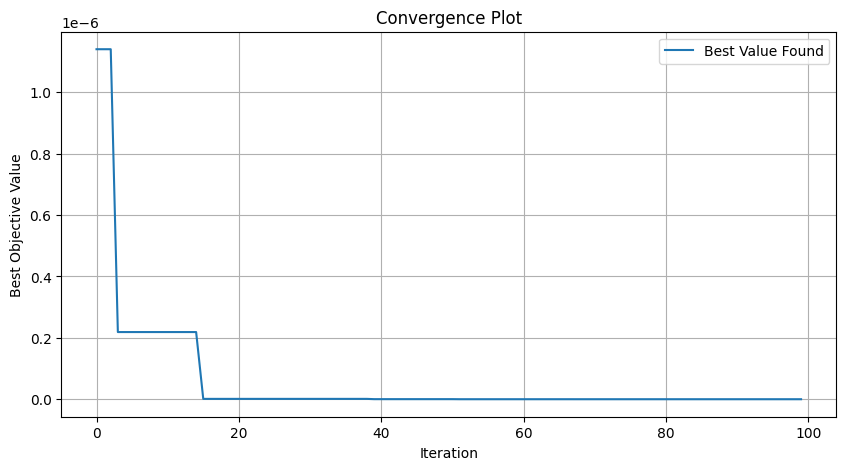

In [7]:
import matplotlib.pyplot as plt

# Track the history of the best value found so far
history = []

# Optimization loop
for i in range(optimizer.budget):
    x = optimizer.ask()
    value = rastrigin(x.value)
    optimizer.tell(x, value)
    recommendation = optimizer.provide_recommendation()
    history.append(rastrigin(recommendation.value))

# Plot the convergence
plt.figure(figsize=(10, 5))
plt.plot(history, label='Best Value Found')
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()


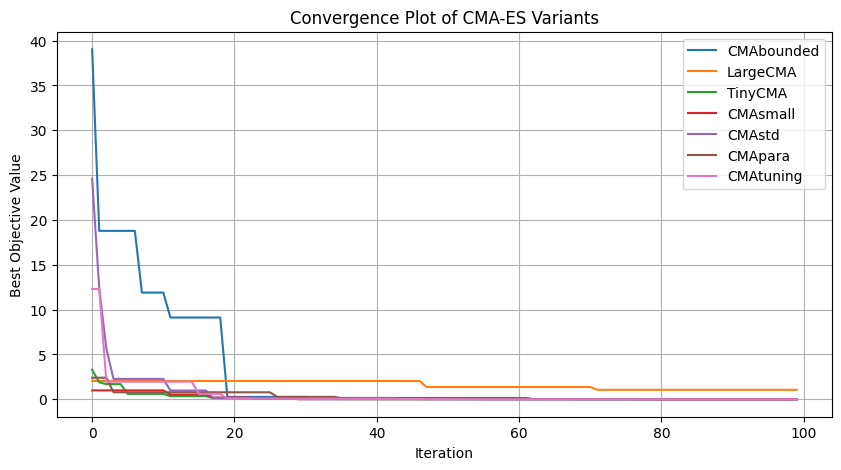

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import nevergrad as ng

# Function to perform the optimization and track convergence
def optimize_and_track(variant, parametrization, budget):
    optimizer = ng.optimizers.registry[variant](parametrization=parametrization, budget=budget)
    history = []
    for _ in range(budget):
        x = optimizer.ask()
        value = rastrigin(x.value)
        optimizer.tell(x, value)
        recommendation = optimizer.provide_recommendation()
        history.append(rastrigin(recommendation.value))
    return history

# Define the Rastrigin function
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Create an optimization problem object
parametrization = ng.p.Array(shape=(2,)).set_bounds(lower=-5.12, upper=5.12)

# List of CMA-ES variants to test
cma_variants = ["CMAbounded", "LargeCMA", "TinyCMA", "CMAsmall", "CMAstd", "CMApara", "CMAtuning"]

# Optimization budget
budget = 100

# Plot convergence for each variant
plt.figure(figsize=(10, 5))

for variant in cma_variants:
    np.random.seed(1)  # Ensure reproducibility
    history = optimize_and_track(variant, parametrization, budget)
    plt.plot(history, label=variant)

# Finalize the plot
plt.xlabel('Iteration')
plt.ylabel('Best Objective Value')
plt.title('Convergence Plot of CMA-ES Variants')
plt.legend()
plt.grid(True)
plt.show()


In Nevergrad, the CMA-ES optimizer has several variations that can be adjusted using different parameters when initializing the optimizer. Here are some of the variations and what they represent【179†source】:

- **scale**: This parameter scales the search space.
- **elitist**: When set to True, the optimizer switches to elitist mode, where the best point is always kept in the population.
- **popsize**: Specifies the population size. If not set, a default is calculated based on the dimension of the problem.
- **popsize_factor**: A factor used in the formula for computing the population size.
- **diagonal**: If True, the optimizer uses a diagonal version of CMA, which is recommended for high dimensions.
- **high_speed**: When True, a metamodel is used for making recommendations, which can speed up the optimization process.
- **fcmaes**: This variation uses a fast CMA-ES implementation that is preferable for high dimensions or when the objective function evaluation is quick. Note that it doesn't support the diagonal option.
- **random_init**: If True, a randomized initialization of the population is used.
- **inopts**: An optional dictionary to override any parameter of the wrapped CMA optimizer.

Each of these variations can affect the performance of the CMA-ES optimizer depending on the characteristics of the optimization problem at hand. For example, using a diagonal covariance matrix can reduce computational complexity for high-dimensional problems, while the fast CMA-ES implementation can be beneficial when the evaluation of the objective function is not computationally expensive. The choice of these variations would typically depend on the specific needs and nature of the optimization problem you are trying to solve.

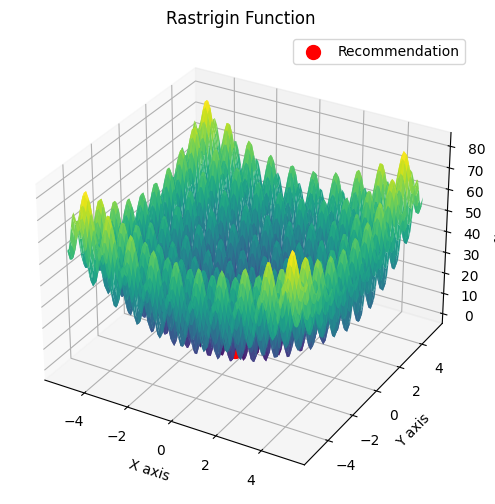

In [12]:

# Rastrigin function for plotting
def rastrigin_plot(X, Y, A=10):
    return (X**2 - A * np.cos(2 * np.pi * X)) + (Y**2 - A * np.cos(2 * np.pi * Y)) + 2 * A

# Create a grid of points
x = np.linspace(-5.12, 5.12, 100)
y = np.linspace(-5.12, 5.12, 100)
X, Y = np.meshgrid(x, y)

# Calculate function values
Z = rastrigin_plot(X, Y)

# Plot the function
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', rstride=1, cstride=1)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('f(x, y)')
ax.set_title('Rastrigin Function')

# Plot the recommendation on the function
# Use the recommendation value from nevergrad optimization here
# For example, if recommendation.value = [x_rec, y_rec]
x_rec, y_rec = recommendation.value
recommendation_value = rastrigin_plot(np.array([x_rec]), np.array([y_rec]))
ax.scatter(x_rec, y_rec, recommendation_value, color='r', s=100, zorder=0, label='Recommendation')

# Show the plot with legend
ax.legend()
plt.show()


The `nevergrad` library provides a common API for all optimizer classes, which includes `CMA` (Covariance Matrix Adaptation Evolution Strategy). Here's an explanation of the API and how it is used in your code:

### Optimizer API in Nevergrad:

`nevergrad.optimizers.base.Optimizer` is the base class for all optimizers in `nevergrad`. It requires the following parameters upon initialization:

- **parametrization**: This can either be an integer representing the dimensionality of the problem or a `Parameter` object that includes domain specifications such as bounds, constraints, etc. In your code, `parametrization` is defined as an `ng.p.Array` object with a shape of `(2,)`, meaning you are optimizing a function with 2 parameters. Additionally, you've set the bounds for each parameter to be within the range [-5.12, 5.12].

- **budget**: This optional integer defines the total number of function evaluations the optimizer can use. The 'budget' provides a way to limit the computational cost of the optimization process. In your code, you set the `budget` to 100, indicating that the optimizer will stop after 100 evaluations of the objective function.

- **num_workers**: This integer specifies the number of evaluations that can be run in parallel. The default value is 1, indicating sequential execution. If you have a system with multiple processors or wish to use asynchronous evaluations, you can increase this number. In your code, you didn't specify this parameter, so it uses the default value of 1.

### Your Code Explained:

1. **Rastrigin Function Definition**: You define the Rastrigin function, which is a non-convex function used as a performance test problem for optimization algorithms. It is known for its large number of local minima.

2. **Optimization Problem Setup**: You create a `parametrization` object that defines the search space. This object tells the optimizer the number of dimensions and the bounds for each dimension.

3. **CMA-ES Optimizer Initialization**: You initialize the `CMA` optimizer with the `parametrization` and `budget`. The `CMA` optimizer uses the Covariance Matrix Adaptation strategy, which is effective for problems like the Rastrigin function.

4. **Optimization Loop**: You run a loop for the number of times specified by the `budget`. In each iteration, you ask the optimizer for a new candidate solution, evaluate the Rastrigin function at that point, and then tell the optimizer the result.

5. **Result Retrieval**: After the optimization loop, you retrieve the best solution found by the optimizer using `optimizer.provide_recommendation()`, and then print the solution and its function value.

In summary, your code is setting up and running an optimization process to find the minimum of the Rastrigin function within the specified bounds and evaluation budget. It demonstrates a typical use of the `nevergrad` optimization library with the CMA-ES algorithm.

The standardized calling process for using the `nevergrad` library with the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) optimizer, as demonstrated in your code, can be summarized as follows:

1. **Import Required Modules**:
   - Import the `nevergrad` library and other necessary Python modules like `numpy`.

2. **Define the Objective Function**:
   - Define the objective function to be optimized. In your case, it's the Rastrigin function, which is known for its challenging optimization landscape.

3. **Set Up the Parametrization**:
   - Define the problem's parametrization by specifying the dimensions and bounds of the search space. This is done using `ng.p.Array` with the shape of the parameter space and the bounds for each parameter.

4. **Initialize the Optimizer**:
   - Create an optimizer object by selecting the desired optimization strategy (CMA-ES) and providing it with the parametrization object. Additionally, set the budget, which is the maximum number of function evaluations allowed.

5. **Perform Optimization**:
   - Enter a loop that runs for the number of iterations specified by the budget.
   - Within each iteration, use the `ask()` method to request a new candidate solution from the optimizer.
   - Evaluate the objective function with the candidate solution.
   - Provide the optimizer with the evaluated value by using the `tell()` method.

6. **Retrieve the Best Solution**:
   - After exhausting the budget, extract the best solution found by the optimizer using the `provide_recommendation()` method.

7. **Display Results**:
   - Print the recommended solution and its associated objective function value.

This process encapsulates a typical optimization workflow where the user has a clear objective function and constraints set. The `nevergrad` library abstracts away the complexity of the optimization algorithm, allowing users to focus on setting up their problem and interpreting the results.

These variations are configurations of the CMA-ES optimizer in nevergrad with different parameter settings:

- **OldCMA**: The original CMA-ES algorithm without any scaling or adjustments.
- **LargeCMA**: A variation with a larger scale factor, which might be suitable for problems with a larger search space.
- **LargeDiagCMA**: Similar to LargeCMA but uses a diagonal covariance matrix, which can be faster for high-dimensional problems.
- **TinyCMA**: A smaller scale factor, potentially useful for more finely-grained searches in a smaller area around the optimum.
- **CMAbounded**: This variation includes bounding mechanisms with a specific scale and population size factor. It is elitist (keeps the best solution) and uses a diagonal covariance matrix.
- **CMAsmall**: A smaller scale and larger population size factor, which is not elitist and does not use a diagonal covariance matrix.
- **CMAstd**: A standard configuration with moderate scale and population size factor, not elitist and without a diagonal covariance matrix.
- **CMApara**: A parameterized variation with a larger scale and population size, elitist, and uses a diagonal covariance matrix, which may be suited for parallel evaluations.
- **CMAtuning**: A tuning-focused variation with elitist selection and no diagonal covariance matrix.

Each variation is suited for different types of optimization problems, based on the problem's scale, dimensionality, and desired convergence behavior. "register=True" means these variations are registered in nevergrad's optimizer registry for easy access.

In [7]:
import numpy as np
import nevergrad as ng

# Define the standard Rastrigin function
def rastrigin(x, A=10):
    return A * len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

# Define a function to create a rotation matrix
def create_rotation_matrix(dim, seed=0):
    np.random.seed(seed)
    random_matrix = np.random.randn(dim, dim)
    q, _ = np.linalg.qr(random_matrix)  # QR decomposition for orthogonality
    return q

# Define the Rotated Rastrigin function
def rotated_rastrigin(x, rotation_matrix):
    y = np.dot(rotation_matrix, x)  # Apply the rotation to the input vector
    return rastrigin(y)

# Dimension of the input
dim = 2
rotation_matrix = create_rotation_matrix(dim)

# Create an optimization problem object
parametrization = ng.p.Array(shape=(dim,)).set_bounds(lower=-5.12, upper=5.12)

# Define your custom CMA-ES parameters (as previously described)
custom_parameters = {
   "scale": 1.0,  # Scales the search space
   "elitist": True,  # Keeps the best point in the population
   "popsize": None,  # Will be calculated based on the dimension if not set
   "popsize_factor": 2,  # Factor for computing the population size
   "diagonal": True,  # Uses a diagonal covariance matrix
   "high_speed": True,  # Uses a metamodel for making recommendations
   "fcmaes": False,  # Uses a fast CMA-ES implementation
   "random_init": True,  # Uses a randomized initializati
}

# Create your custom CMA-ES optimizer
CustomCMA = ng.optimizers.ParametrizedCMA(**custom_parameters).set_name("CustomCMA", register=True)
optimizer = CustomCMA(parametrization=parametrization, budget=100)

# Optimization loop
for _ in range(optimizer.budget):
    x = optimizer.ask()
    value = rotated_rastrigin(x.value, rotation_matrix)
    optimizer.tell(x, value)

# Retrieve the best solution
recommendation = optimizer.provide_recommendation()
print(f"Custom variation best value: {rotated_rastrigin(recommendation.value, rotation_matrix)}")


RuntimeError: Encountered a name collision "CustomCMA"

In [ ]:
# 错误处理和故障排除提示 (Error Handling and Troubleshooting Tips)

## 概述 (Overview)
本文档提供在使用 Nevergrad 库中的 CMA-ES 优化器及其变体时可能遇到的常见错误及其解决方案的参考。目标是帮助用户有效地识别和解决问题，以确保优化过程的顺利进行。

## 常见错误及其解决方案 (Common Errors and Solutions)

### 名称冲突错误 (Name Collision Error)
**错误信息**: `RuntimeError: Encountered a name collision "CustomCMA"`

**原因**: 尝试将已存在的优化器名称注册到 Nevergrad 的注册表中。

**解决方案**: 
- 使用唯一的名称注册优化器。
- 直接实例化优化器而不进行注册。

### 参数错误 (Parameter Error)
**错误信息**: `TypeError: got unexpected keyword argument`

**原因**: 传递了不支持的参数或拼写错误的参数给优化器。

**解决方案**: 
- 确保所有参数名称和类型都是正确的。
- 查阅 Nevergrad 文档以确认支持的参数。

### 预算不足错误 (Insufficient Budget Error)
**错误信息**: `ValueError: Budget must be at least ...`

**原因**: 为优化器指定的预算小于其运行所需的最小迭代次数。

**解决方案**: 
- 增加优化器的预算参数。

### 不支持的优化器变体 (Unsupported Optimizer Variant)
**错误信息**: `KeyError: '...variant name...'`

**原因**: 尝试访问未在当前版本的 Nevergrad 中注册的优化器变体。

**解决方案**: 
- 确认变体名称是否正确。
- 更新 Nevergrad 到最新版本或手动注册缺失的变体。

## 最佳实践 (Best Practices)

- **测试和验证**: 在将优化器应用到复杂问题之前，先在简单的测试函数上进行验证。
- **逐步调试**: 在遇到问题时，逐步执行代码，以便更容易地定位问题的根源。
- **文档参考**: 常常查阅官方文档来获取最新和最准确的信息。
- **随机种子**: 在进行优化时设定随机种子以保证结果的可重现性。
- **版本兼容性**: 使用与项目兼容的 Nevergrad 版本，并注意版本更新可能带来的变化。

## 结论 (Conclusion)
遵循本文档中提供的故障排除步骤和最佳实践，可以帮助用户避免和解决在使用 Nevergrad 中的 CMA-ES 优化器及其变体时可能遇到的常见问题。



Here is a detailed version in English that you can use to insert into a Word document:

---

### Name Collision Error
**Error Message**: `RuntimeError: Encountered a name collision "CustomCMA"`

**Cause**: Attempting to register an optimizer with a name that already exists in Nevergrad’s registry.

**Solution**: 
- Register the optimizer using a unique name.
- Instantiate the optimizer directly without registering it.

### Parameter Error
**Error Message**: `TypeError: got an unexpected keyword argument`

**Cause**: Passing unsupported or misspelled parameters to the optimizer.

**Solution**: 
- Ensure all parameter names and types are correct.
- Refer to Nevergrad documentation to confirm supported parameters.

### Insufficient Budget Error
**Error Message**: `ValueError: Budget must be at least ...`

**Cause**: The specified budget for the optimizer is less than the minimum number of iterations required for operation.

**Solution**: 
- Increase the budget parameter for the optimizer.

### Unsupported Optimizer Variant
**Error Message**: `KeyError: '...variant name...'`

**Cause**: Attempting to access an optimizer variant that is not registered in the current version of Nevergrad.

**Solution**: 
- Verify if the variant name is correct.
- Update Nevergrad to the latest version or manually register the missing variant.

---

You can copy this text into a Microsoft Word document, and it will retain the formatting. Make sure to check the document for any additional formatting needs you may have.

Troubleshooting tips

- **Testing and Verification**: Validate the optimizer on simple test functions before applying it to complex problems.
- **Incremental Debugging**: Execute your code step-by-step when encountering issues to more easily identify the root cause.
- **Documentation Reference**: Regularly consult the official documentation for the most updated and accurate information.
- **Random Seed**: Set a random seed during optimization to ensure the reproducibility of results.
- **Version Compatibility**: Use the version of Nevergrad that is compatible with your project and be aware of changes that may come with updates.